<a href="https://colab.research.google.com/github/ryanhikmall/vehicle-classification-svm/blob/main/vehicle_classification_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# menghubungkan ke ke drive dan membaca data set


In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Path yang benar harus diawali dengan /content/drive/MyDrive/
base_dir = '/content/drive/MyDrive/uas_citra /dataset_tol'

# Cek isi folder untuk memastikan
if os.path.exists(base_dir):
    print("Folder ditemukan:", os.listdir(base_dir))
else:
    print("Folder tidak ditemukan! Cek path Anda lagi.")

Mounted at /content/drive
Folder ditemukan: ['Truck', 'Car', 'Bus']


# Preprocessing

Mulai proses Preprocessing & Loading Data...

--> Memproses Folder: Bus...


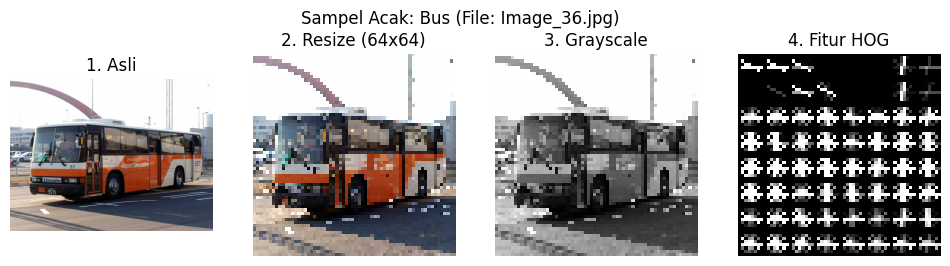


--> Memproses Folder: Car...


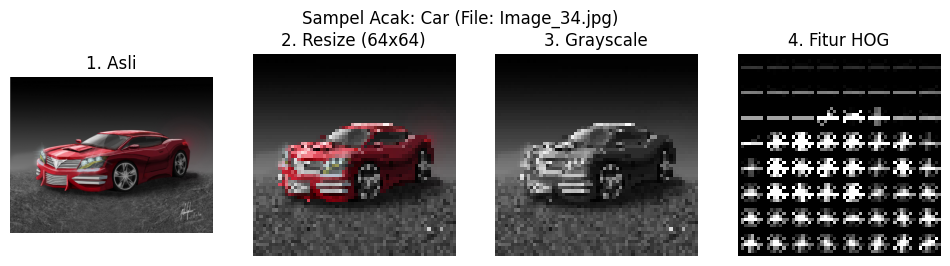


--> Memproses Folder: Truck...


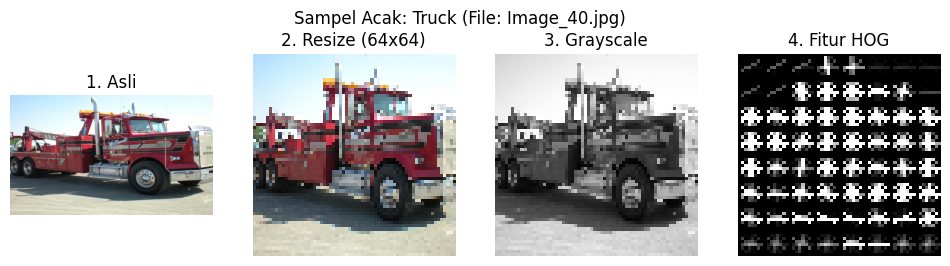


PROSES SELESAI!
Total Data Terkumpul: 300


In [ ]:
from skimage.feature import hog
from skimage import exposure
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random  # <--- Wajib import ini

def load_data_hog_random_visual(directory):
    data = []
    labels = []

    # Pastikan urutan kelas konsisten
    classes = sorted([c for c in os.listdir(directory) if c in ['Car', 'Bus', 'Truck', 'Motorcycle']])

    print("Mulai proses Preprocessing & Loading Data...")

    for category in classes:
        path = os.path.join(directory, category)
        class_num = classes.index(category)

        print(f"\n--> Memproses Folder: {category}...")

        # Flag agar kita cuma menampilkan 1 gambar per kategori
        sudah_tampil_contoh = False

        if not os.path.exists(path):
            print(f"    PERINGATAN: Folder {category} tidak ditemukan!")
            continue

        # --- BAGIAN PENGACAKAN ---
        # 1. Ambil semua nama file
        all_files = os.listdir(path)
        # 2. Acak urutannya! (Ini kuncinya)
        random.shuffle(all_files)

        # Sekarang kita loop file yang sudah diacak
        for img_name in all_files:
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)

                if img is not None:
                    # --- TAHAP 1: RESIZE ---
                    img_resized = cv2.resize(img, (64, 64))

                    # --- TAHAP 2: GRAYSCALE ---
                    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

                    # --- TAHAP 3: HOG (UNTUK DATA TRAINING) ---
                    features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=False)

                    data.append(features)
                    labels.append(class_num)

                    # --- BAGIAN VISUALISASI (1x per Folder, tapi sekarang gambarnya acak) ---
                    if not sudah_tampil_contoh:
                        # Kita hitung HOG lagi dengan visualize=True KHUSUS untuk display
                        _, hog_image = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                                           cells_per_block=(2, 2), visualize=True)

                        # Perjelas gambar HOG
                        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

                        # Plotting
                        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
                        # Tampilkan nama filenya di judul agar tahu ini gambar yg mana
                        fig.suptitle(f"Sampel Acak: {category} (File: {img_name})", fontsize=12)

                        # Gambar Asli
                        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        ax1.set_title("1. Asli")
                        ax1.axis('off')

                        # Resize
                        ax2.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
                        ax2.set_title("2. Resize (64x64)")
                        ax2.axis('off')

                        # Grayscale
                        ax3.imshow(img_gray, cmap='gray')
                        ax3.set_title("3. Grayscale")
                        ax3.axis('off')

                        # HOG
                        ax4.imshow(hog_image_rescaled, cmap='gray')
                        ax4.set_title("4. Fitur HOG")
                        ax4.axis('off')

                        plt.show()
                        sudah_tampil_contoh = True # Stop visualisasi setelah 1 gambar

            except Exception as e:
                pass

    return np.array(data), np.array(labels), classes

# JALANKAN FUNGSI
if 'base_dir' in globals():
    X, y, class_names = load_data_hog_random_visual(base_dir)
    print("\nPROSES SELESAI!")
    print(f"Total Data Terkumpul: {len(X)}")
else:
    print("Error: Jalankan Cell 1 dulu untuk mendefinisikan 'base_dir'.")

#split data and training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1. SPLIT DATA (Sesuai Jurnal: 80% Latih, 20% Uji)
print("Sedang membagi data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"--> Jumlah Data Training : {len(X_train)} gambar")
print(f"--> Jumlah Data Testing  : {len(X_test)} gambar")

# 2. MODEL KNN (Sebagai Pembanding)
print("\n[1] Sedang melatih KNN (n=5)...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("    Selesai! Melakukan prediksi KNN...")
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print(f"    Akurasi KNN: {knn_acc * 100:.2f}%")

# 3. MODEL SVM (Model Utama - Optimized)
print("\n[2] Sedang melatih SVM (Kernel RBF)...")
# Saya ganti ke RBF agar lebih akurat untuk fitur HOG
svm = SVC(kernel='rbf', C=10, probability=True)
svm.fit(X_train, y_train)
print("    Selesai! Melakukan prediksi SVM...")
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"    Akurasi SVM: {svm_acc * 100:.2f}%")

# Kesimpulan Singkat
print("\n===========================================")
if svm_acc > knn_acc:
    print(f"REKOMENDASI: Gunakan SVM (Lebih unggul {(svm_acc - knn_acc)*100:.2f}%)")
else:
    print("REKOMENDASI: Gunakan KNN")
print("===========================================")

#visualisasi confusion matrix


===== HASIL METODE KNN =====
Akurasi: 48.33%

Classification Report:
              precision    recall  f1-score   support

         Bus       0.49      0.91      0.63        22
         Car       0.55      0.38      0.44        16
       Truck       0.38      0.14      0.20        22

    accuracy                           0.48        60
   macro avg       0.47      0.47      0.43        60
weighted avg       0.46      0.48      0.42        60



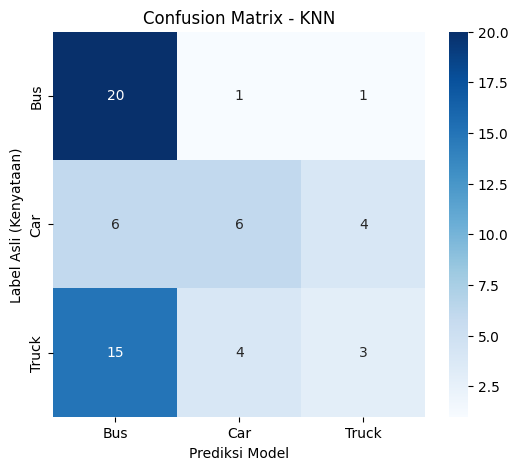


===== HASIL METODE SVM =====
Akurasi: 68.33%

Classification Report:
              precision    recall  f1-score   support

         Bus       0.71      0.91      0.80        22
         Car       0.67      0.62      0.65        16
       Truck       0.65      0.50      0.56        22

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.67        60
weighted avg       0.68      0.68      0.67        60



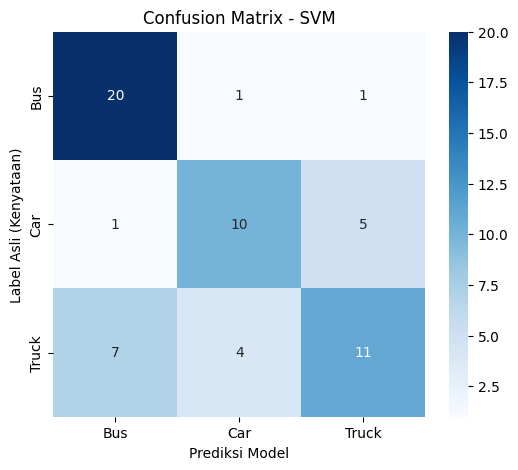

In [ ]:
def show_results(y_true, y_pred, model_name):
    print(f"\n===== HASIL METODE {model_name} =====")

    # 1. Akurasi
    acc = accuracy_score(y_true, y_pred)
    print(f"Akurasi: {acc*100:.2f}%")

    # 2. Laporan Detail (Precision, Recall, F1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Asli (Kenyataan)')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Tampilkan Hasil
show_results(y_test, knn_pred, "KNN")
show_results(y_test, svm_pred, "SVM")

#demo prediction

===== DEMO PREDIKSI (METODE HOG) =====


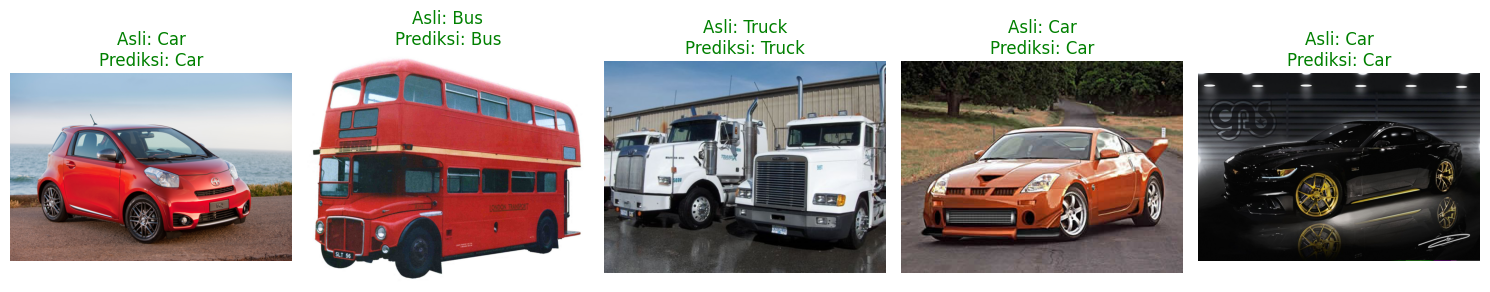

In [ ]:
# --- CELL DEMO PREDIKSI KHUSUS HOG ---
import random
from skimage.feature import hog

def demo_prediksi_hog(model, base_dir, classes, jumlah_contoh=5):
    plt.figure(figsize=(15, 4))

    # Ambil beberapa sample acak langsung dari folder
    # Agar kita bisa menampilkan gambar aslinya
    for i in range(jumlah_contoh):
        # 1. Pilih Kelas Acak & Gambar Acak
        true_label_name = random.choice(classes)
        true_label_idx = classes.index(true_label_name)
        folder_path = os.path.join(base_dir, true_label_name)

        # Cek folder ada isinya
        if not os.path.exists(folder_path) or not os.listdir(folder_path):
            continue

        filename = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, filename)

        # 2. Baca Gambar (Untuk Ditampilkan)
        img_original = cv2.imread(img_path)
        if img_original is None: continue

        # 3. Proses HOG (Untuk Ditebak Model)
        # Langkah ini HARUS sama persis dengan preprocessing saat training tadi
        img_resized = cv2.resize(img_original, (64, 64))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Hitung fitur HOG
        features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        # 4. Prediksi
        prediksi_idx = model.predict([features])[0]
        prediksi_name = classes[prediksi_idx]

        # 5. Visualisasi
        plt.subplot(1, jumlah_contoh, i+1)
        # Tampilkan gambar asli (berwarna), bukan fitur HOG
        plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Warna teks: Hijau jika benar, Merah jika salah
        color = 'green' if prediksi_idx == true_label_idx else 'red'
        plt.title(f"Asli: {true_label_name}\nPrediksi: {prediksi_name}", color=color)

    plt.tight_layout()
    plt.show()

# Jalankan Demo
print("===== DEMO PREDIKSI (METODE HOG) =====")
# Pastikan 'svm' dan 'base_dir' sudah ada
demo_prediksi_hog(svm, base_dir, class_names)

#testing uploud

In [ ]:
from google.colab import files
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2
import numpy as np

def prediksi_upload_sendiri(model, classes):
    print("===== UPLOAD FOTO UNTUK DITES =====")


    # 1. Widget Upload File
    uploaded = files.upload()

    for fn in uploaded.keys():
        # 2. Baca file gambar
        path = fn
        img = cv2.imread(path)

        if img is None:
            print(f"Gagal membaca file {fn}")
            continue

        # 3. Tampilkan Gambar Asli (Biar Puas Melihatnya)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"File: {fn}", fontsize=12)
        plt.show()

        # 4. PREPROCESSING (Wajib sama persis dengan saat Training)
        # a. Resize ke 64x64
        img_resized = cv2.resize(img, (64, 64))
        # b. Grayscale
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        # c. Hitung HOG
        features = hog(img_gray,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       visualize=False)

        # 5. PREDIKSI
        # Model SVM menebak berdasarkan fitur HOG tadi
        prediksi_index = model.predict([features])[0]
        hasil_tebakan = classes[prediksi_index]

        # 6. Tampilkan Hasil Teks Besar
        print(f"🤖 HASIL PREDICTION MODEL SVM")
        print(f"Saya mendeteksi ini adalah: >> {hasil_tebakan.upper()} <<")

# Jalankan Fungsi
# Pastikan Anda menggunakan model terbaik (misal: svm)
prediksi_upload_sendiri(svm, class_names)

===== UPLOAD FOTO UNTUK DITES =====


#final kode

===== WEBSITE E-TICKETING FERRY (ASDP) =====
Silakan upload foto kendaraan untuk pemesanan tiket...


Saving Screenshot 2026-01-22 024930.png to Screenshot 2026-01-22 024930 (1).png


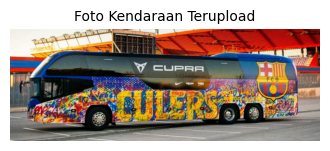

       INVOICE PEMESANAN TIKET ONLINE       
 ID Booking      : BOOK-3521-2026-01-21
 Tanggal         : 2026-01-21 18:50
---------------------------------------------
 Deteksi Sistem  : BUS
 Kategori Tiket  : Bus Penumpang (Golongan VI)
 Keterangan      : Bus Pariwisata/AKAP
---------------------------------------------
 TOTAL TAGIHAN   : Rp 1.500.000
 [TOMBOL: LANJUT KE PEMBAYARAN] 



In [ ]:
# --- LOGIKA BARU: E-TICKETING WEBSITE ---
import random
import datetime

def hitung_harga_tiket_website(prediksi_ai):
    """
    Fungsi ini mengubah hasil prediksi AI menjadi
    Kategori Tiket dan Harga untuk Website.
    """
    label = prediksi_ai.lower()

    # Harga Tiket (Misal: Tiket Kapal Penyeberangan)
    if label == 'car':
        kategori = "Kendaraan Pribadi (Golongan IV-A)"
        harga = 450000 # Rp 450.000
        deskripsi = "Mobil Sedan/Minibus/Jip"

    elif label == 'bus':
        kategori = "Bus Penumpang (Golongan VI)"
        harga = 1500000 # Rp 1.500.000
        deskripsi = "Bus Pariwisata/AKAP"

    elif label == 'truck':
        kategori = "Kendaraan Logistik (Golongan V)"
        harga = 900000 # Rp 900.000
        deskripsi = "Truk Barang/Fuso"

    elif label == 'motorcycle':
        kategori = "Sepeda Motor (Golongan II)"
        harga = 60000 # Rp 60.000
        deskripsi = "Kendaraan Roda Dua"

    else:
        return None, 0, "Tidak Dikenali"

    return kategori, harga, deskripsi

def simulasi_website_ticket_order(model, classes):
    print("===== WEBSITE E-TICKETING FERRY (ASDP) =====")
    print("Silakan upload foto kendaraan untuk pemesanan tiket...")

    # 1. User Upload Foto (Simulasi Input Website)
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = fn
        img = cv2.imread(path)
        if img is None: continue

        # --- AI BEKERJA DI BACKEND ---
        # a. Preprocessing
        img_resized = cv2.resize(img, (64, 64))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

        # b. Prediksi
        prediksi_idx = model.predict([features])[0]
        hasil_ai = classes[prediksi_idx]

        # c. Hitung Harga (Logika Bisnis)
        kategori, harga, deskripsi = hitung_harga_tiket_website(hasil_ai)

        # d. Generate Nomor Booking
        booking_id = f"BOOK-{random.randint(1000,9999)}-{datetime.date.today()}"

        # --- TAMPILAN DI LAYAR USER (WEBSITE) ---
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Foto Kendaraan Terupload", fontsize=10)
        plt.show()

        if kategori:
            print(f"=============================================")
            print(f"       INVOICE PEMESANAN TIKET ONLINE       ")
            print(f"=============================================")
            print(f" ID Booking      : {booking_id}")
            print(f" Tanggal         : {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")
            print(f"---------------------------------------------")
            print(f" Deteksi Sistem  : {hasil_ai.upper()}")
            print(f" Kategori Tiket  : {kategori}")
            print(f" Keterangan      : {deskripsi}")
            print(f"---------------------------------------------")
            print(f" TOTAL TAGIHAN   : Rp {harga:,}".replace(',', '.'))
            print(f"=============================================")
            print(f" [TOMBOL: LANJUT KE PEMBAYARAN] \n")
        else:
            print("ERROR: Jenis kendaraan tidak dikenali. Silakan hubungi CS.")

# JALANKAN SIMULASI
simulasi_website_ticket_order(svm, class_names)